In [2]:
%pylab inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import requests
import re
import datetime
import json
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt

def getOptionSet(table,option):
    return {x[option] for x in table}

def structureData(data, keys):
    if 0 == len(keys):
        return data
    return {opt: structureData([x for x in data if opt==x[keys[0]]],keys[1:]) for opt in getOptionSet(data,keys[0])}

def getNumber(x):
    if x is None:
        return 0
    tmp = re.search('[0-9]+', x)
    if tmp is None:
        return 0
    return int(tmp.group())

def filterByValue(data, key, val):
    return [x for x in data if x[key] == val]

def sortRiscCls(x):
    return {'AA': 0,'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'HR': 7, None: 8}[x[0]]

def barStacked(data, xLabel='category', yLabel='rel', title='', sortLabels=getNumber, sortX=sortRiscCls, normalize=True):
    if 0 == len(data):
        print('empty dataset')
        return
    categories = set({})
    for c in data.values():
        categories.update(c.keys())
    N = len(data.keys())
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    dataItems = sorted(data.items(), key=sortX)
    keys = [x[0] for x in dataItems]
    vals = [x[1] for x in dataItems]
   
    
    catList = sorted(list(categories), key=sortLabels)
    plotData = [[len(d[c]) if c in d else 0 for d in data.values()] for c in catList]
    plotOffsets = [np.zeros(len(plotData[0]))]
    for i, d in enumerate(plotData):
        plotOffsets.append(plotOffsets[i] + np.array(d))
        
    if normalize is True:
        plotData = np.array(plotData) / plotOffsets[-1]
        plotOffsets = np.array(plotOffsets) / plotOffsets[-1]

    p = [plt.bar(ind, d, width, bottom=plotOffsets[i]) for i,d in enumerate(plotData)]

    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    plt.title(title)
    
    plt.xticks(ind, keys)
    plt.legend([x[0] for x in p], catList)

    plt.show()
    
def pieChart(dataDict):
    fig1, ax1 = plt.subplots()
    ax1.pie(dataDict.values(), labels=dataDict.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()  

payload = pickle.load(open('pubdatapayload_complete.pickle','rb'))

loansByYear = {y: [x for x in payload if '{}'.format(y) == x['FirstPaymentDate'][:4]] for y in range(2011,2020)}


Populating the interactive namespace from numpy and matplotlib


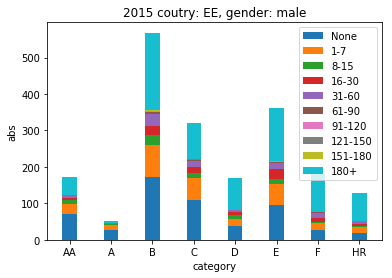

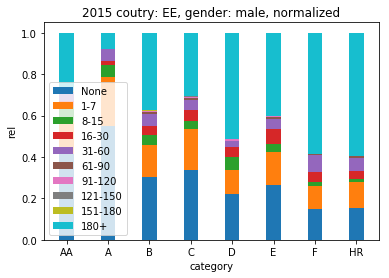

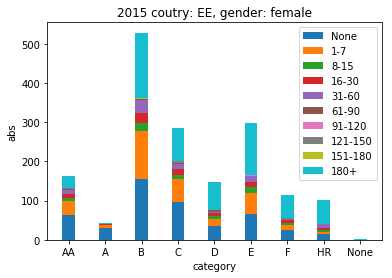

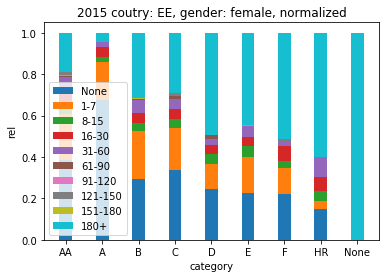

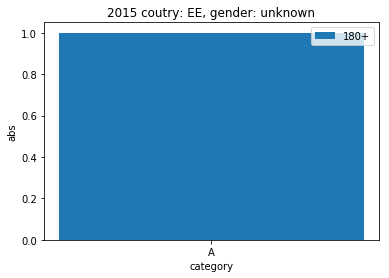

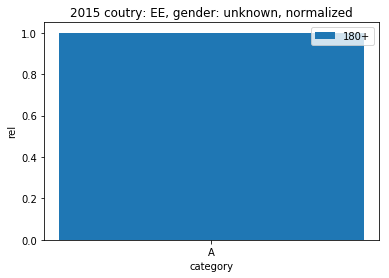

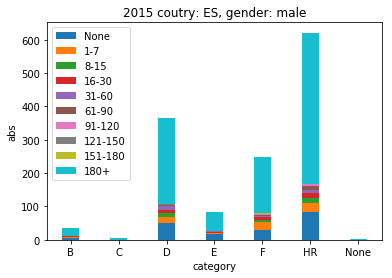

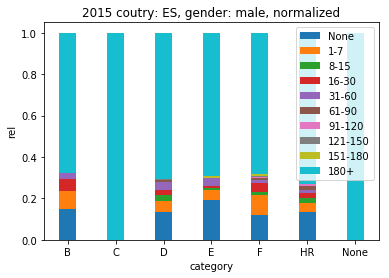

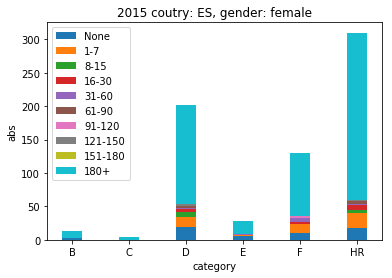

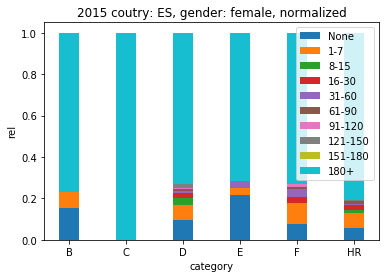

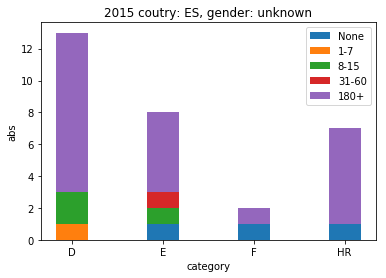

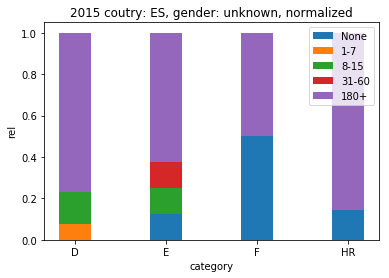

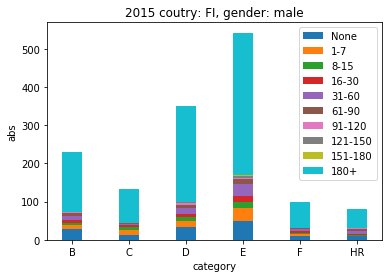

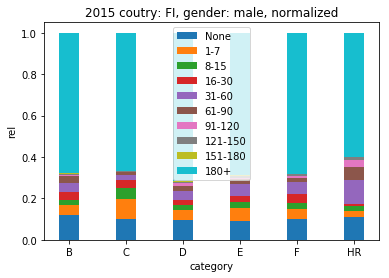

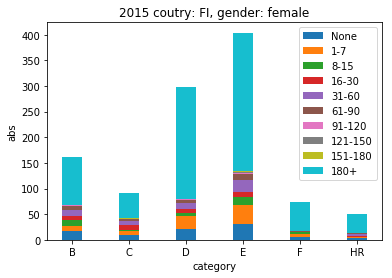

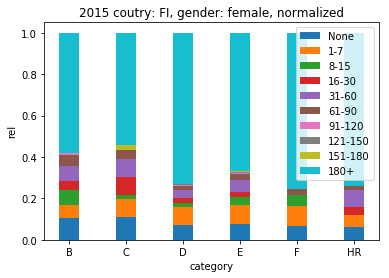

empty dataset
empty dataset


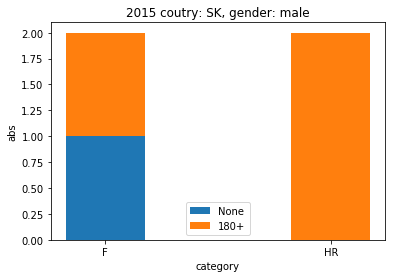

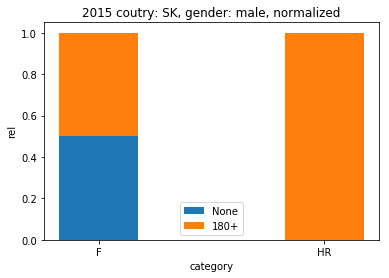

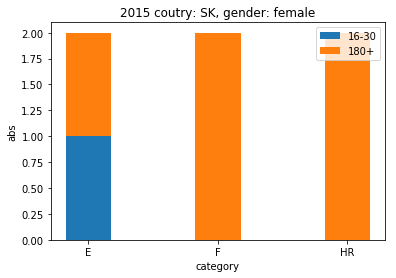

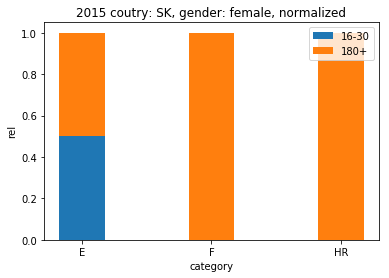

empty dataset
empty dataset


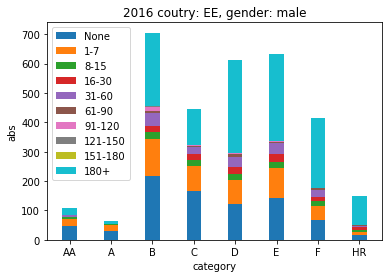

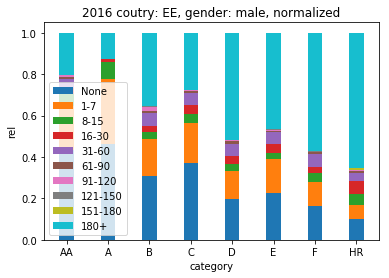

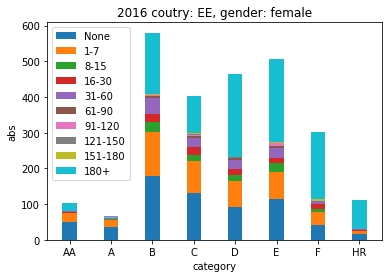

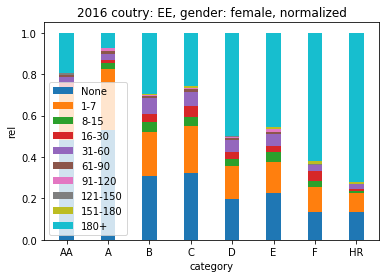

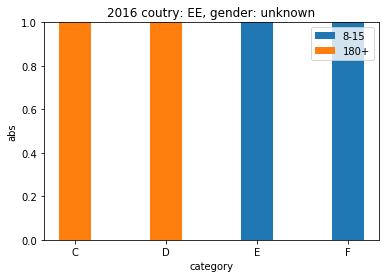

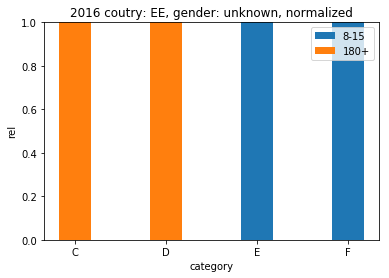

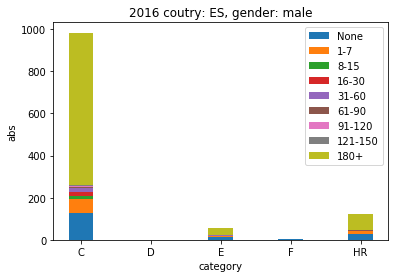

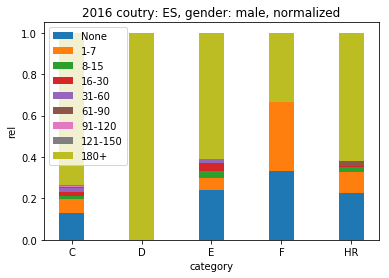

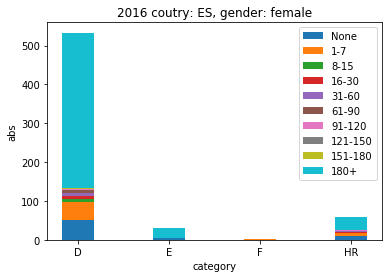

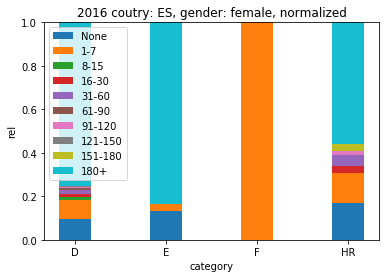

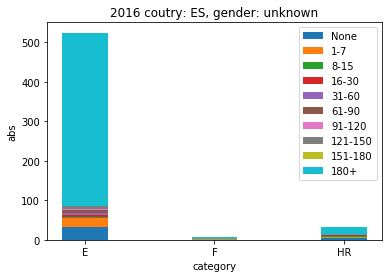

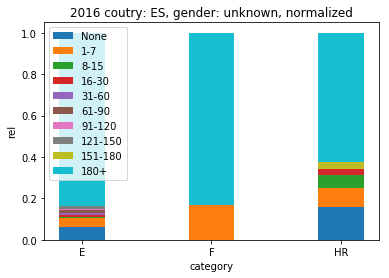

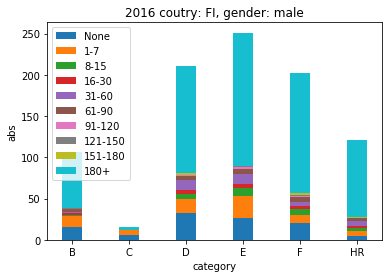

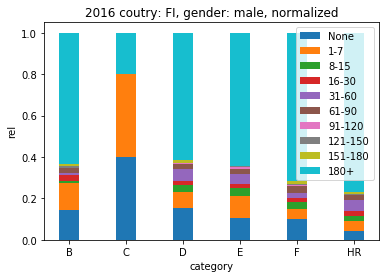

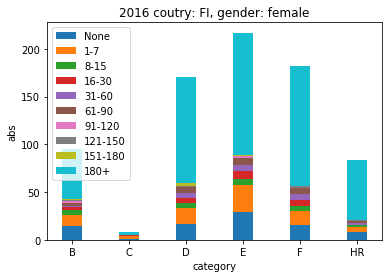

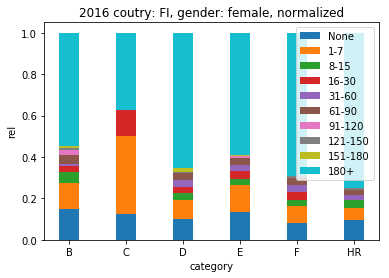

empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset


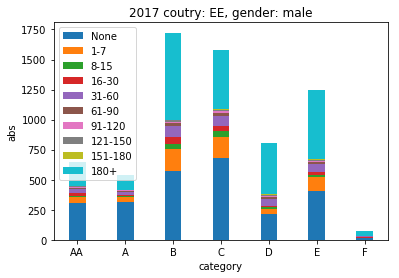

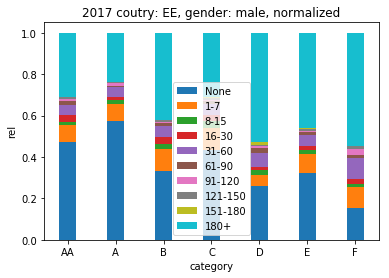

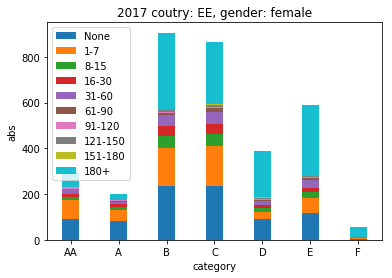

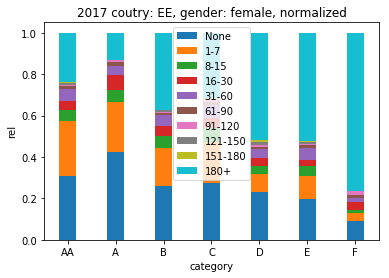

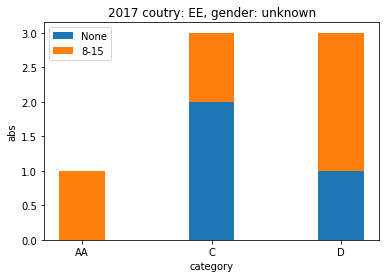

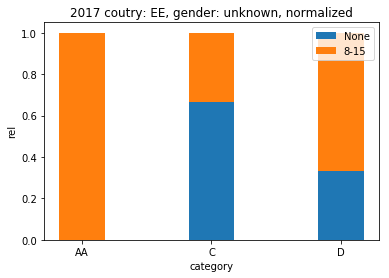

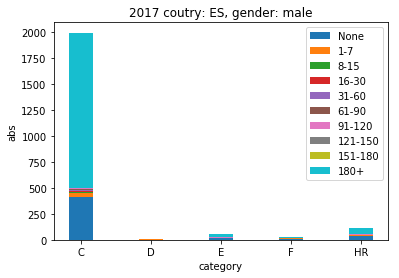

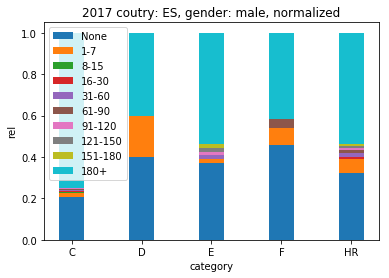

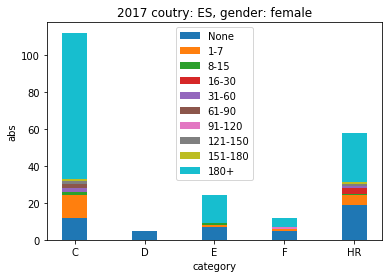

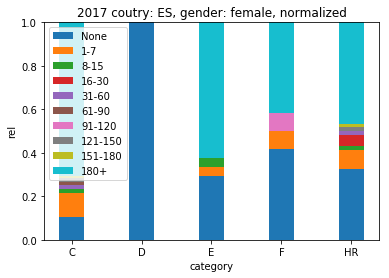

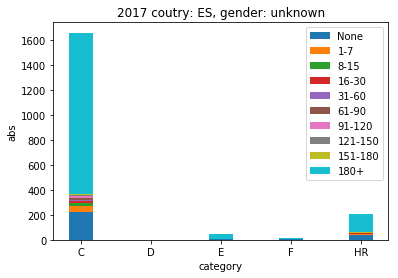

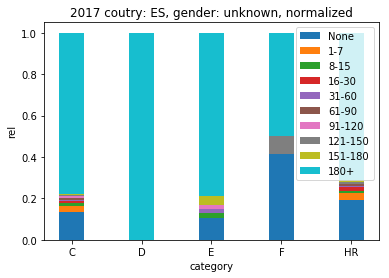

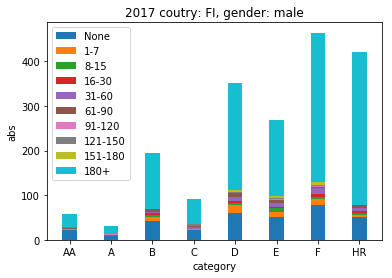

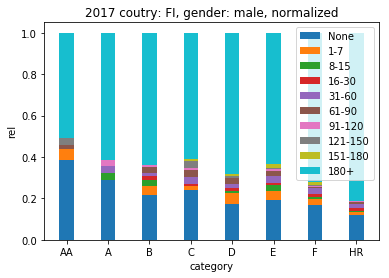

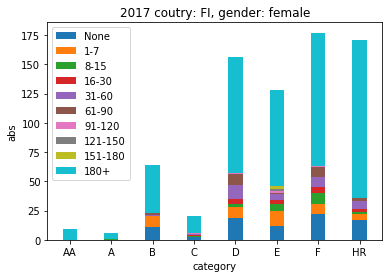

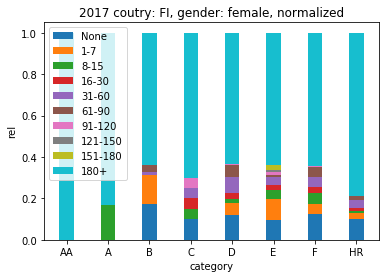

empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset


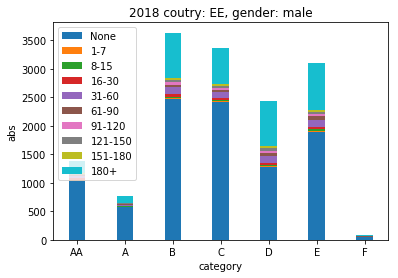

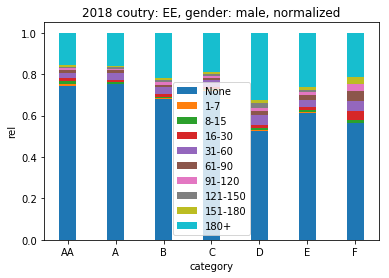

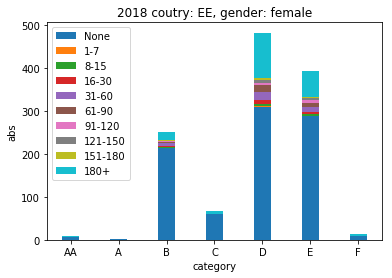

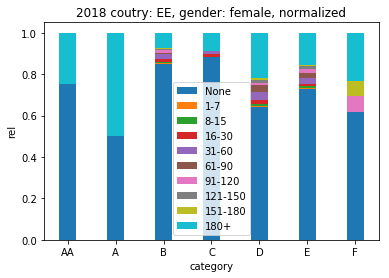

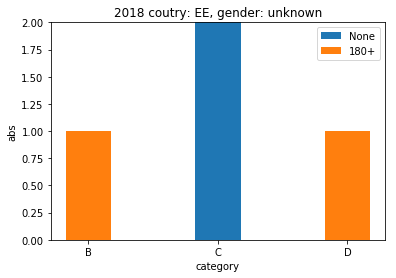

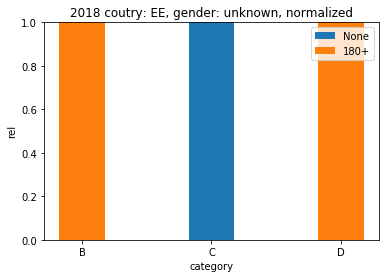

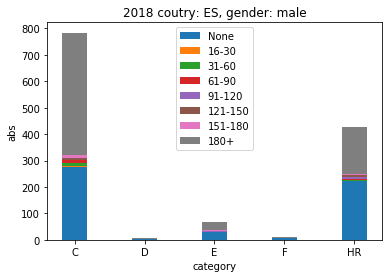

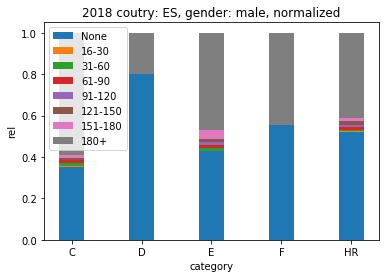

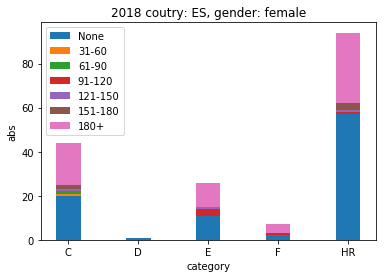

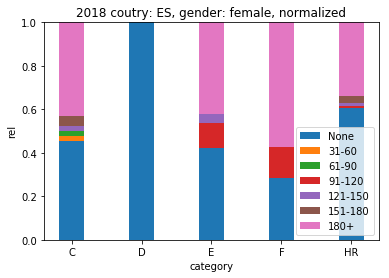

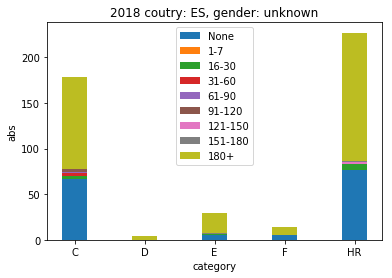

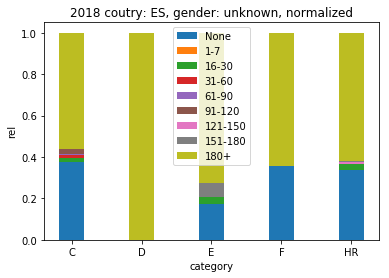

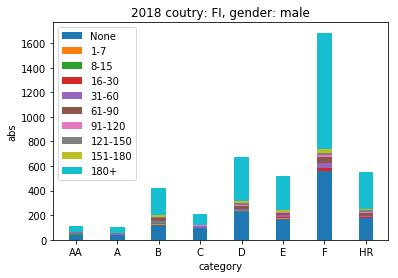

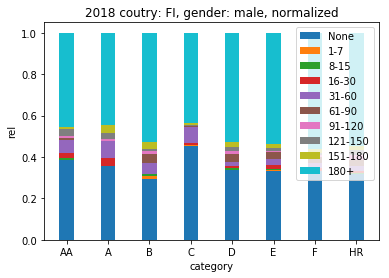

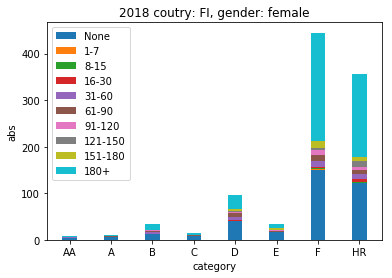

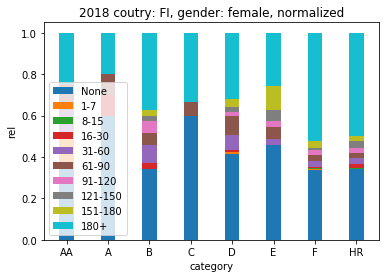

empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset


In [3]:
for year in range(2015,2019):
    for country in ['EE', 'ES', 'FI', 'SK']:
        for gender in [0, 1, 2]:
            barStacked(structureData(filterByValue(filterByValue(loansByYear[year], 'Country', country), 'Gender', gender), ['Rating','WorseLateCategory']),title='{} coutry: {}, gender: {}'.format(year, country, {0: 'male', 1: 'female', 2: 'unknown'}[gender]),yLabel='abs',normalize=False)
            barStacked(structureData(filterByValue(filterByValue(loansByYear[year], 'Country', country), 'Gender', gender), ['Rating','WorseLateCategory']),title='{} coutry: {}, gender: {}, normalized'.format(year, country, {0: 'male', 1: 'female', 2: 'unknown'}[gender]))


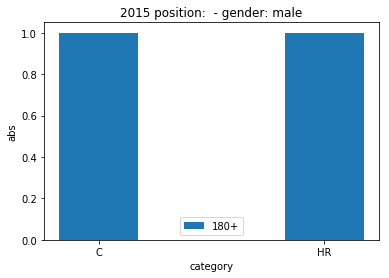

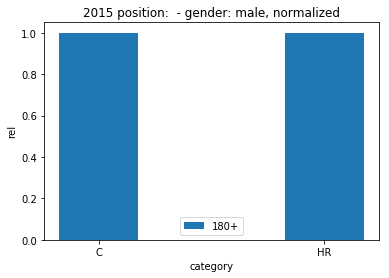

empty dataset
empty dataset
empty dataset
empty dataset


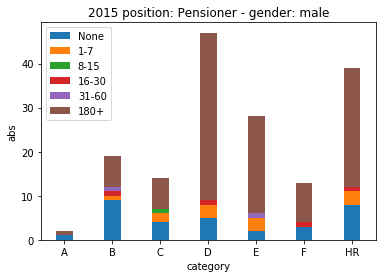

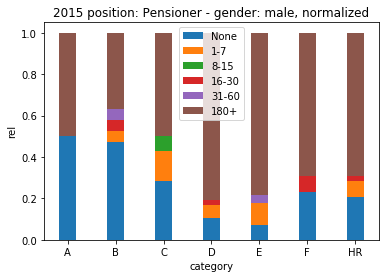

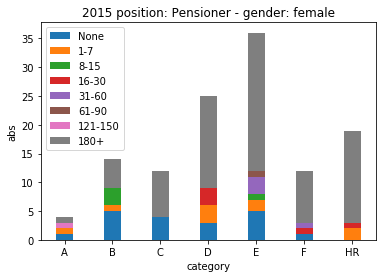

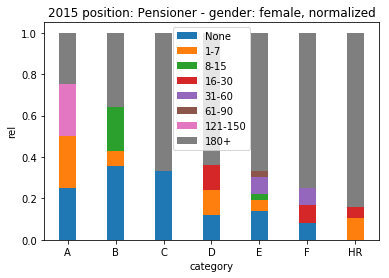

empty dataset
empty dataset


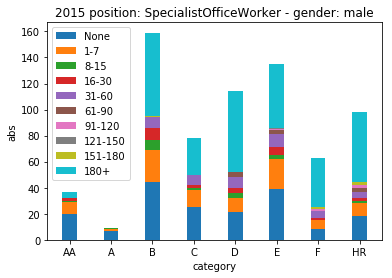

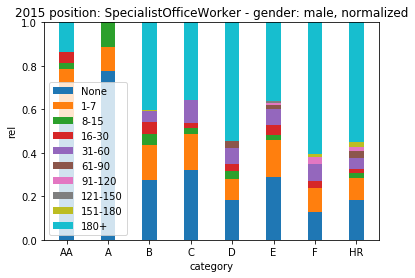

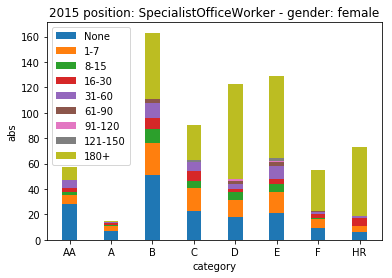

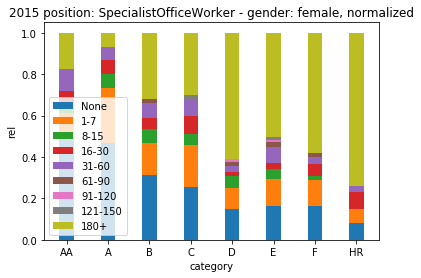

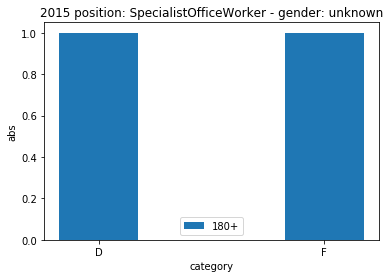

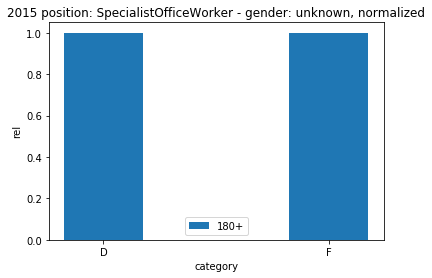

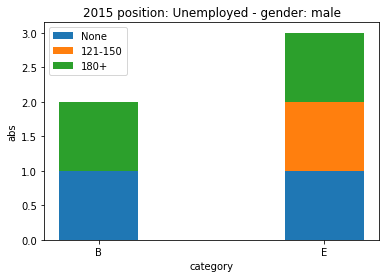

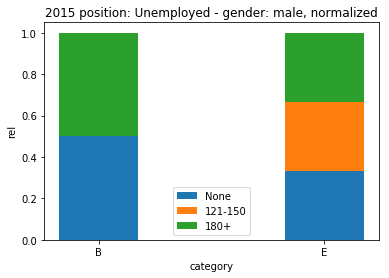

empty dataset
empty dataset
empty dataset
empty dataset


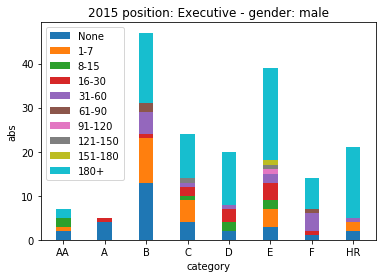

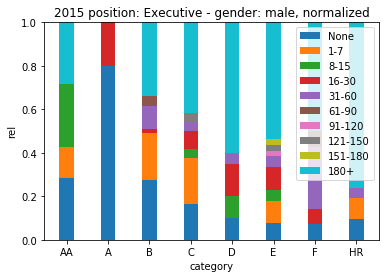

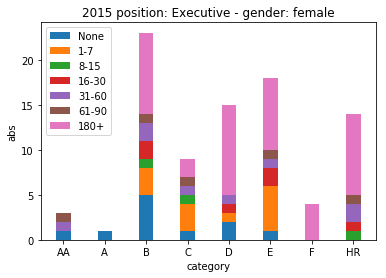

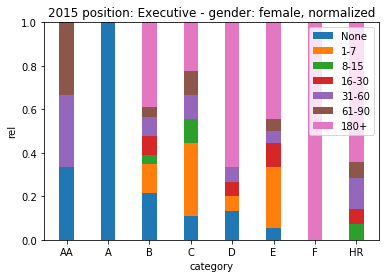

empty dataset
empty dataset


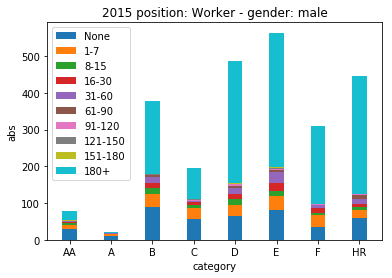

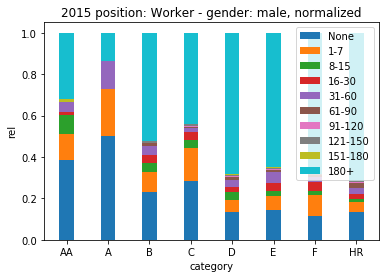

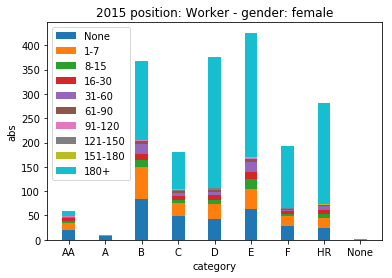

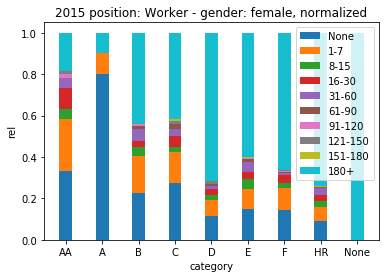

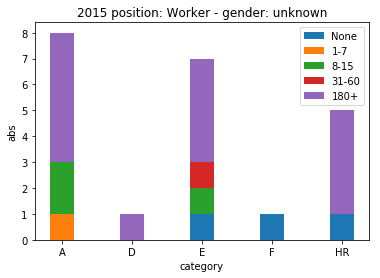

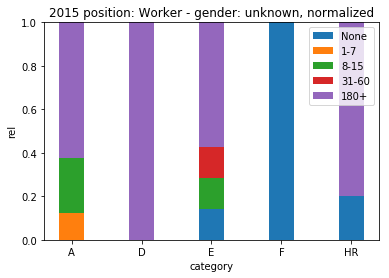

empty dataset
empty dataset


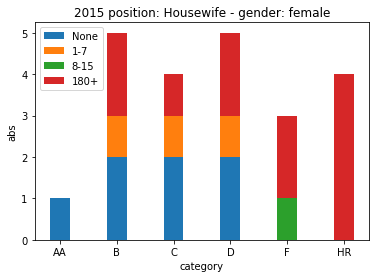

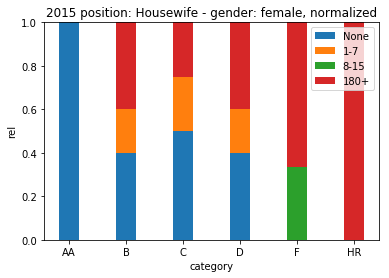

empty dataset
empty dataset


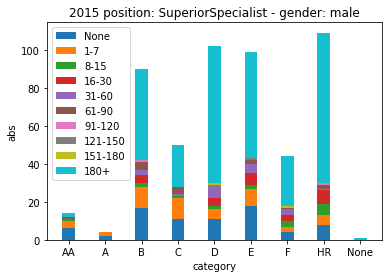

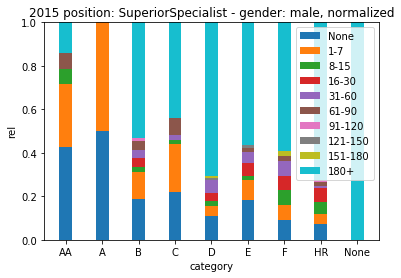

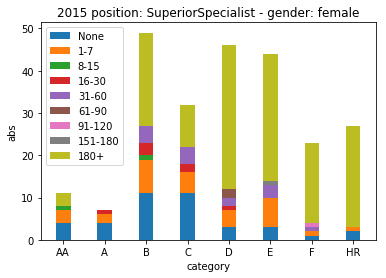

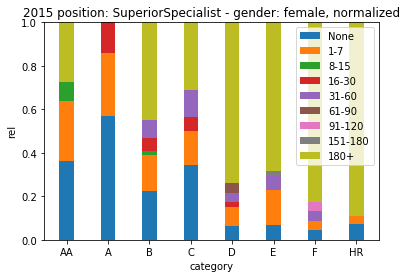

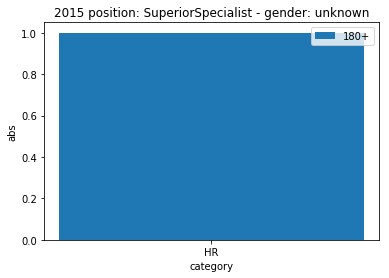

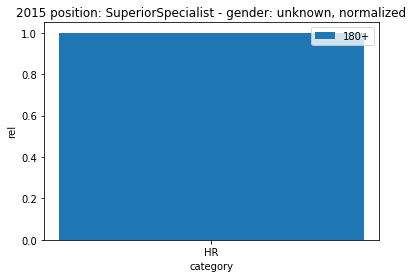

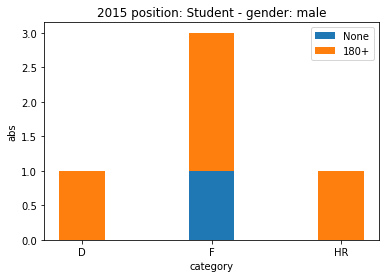

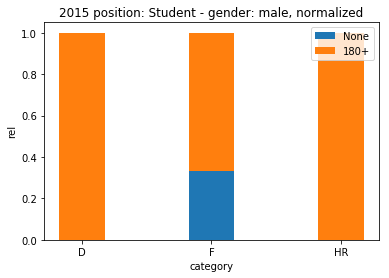

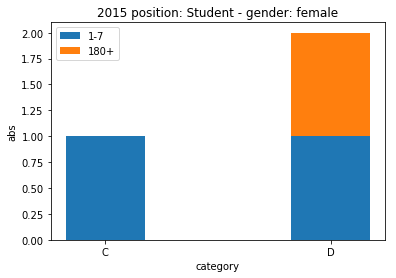

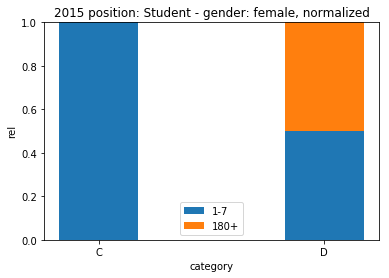

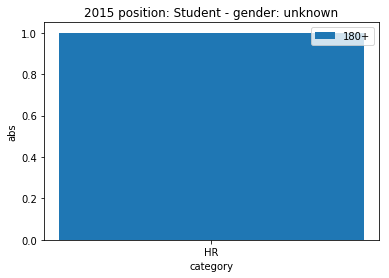

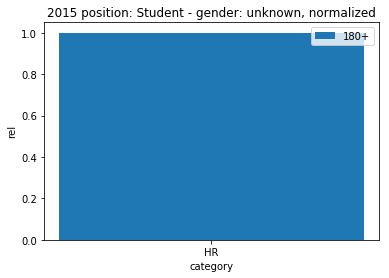

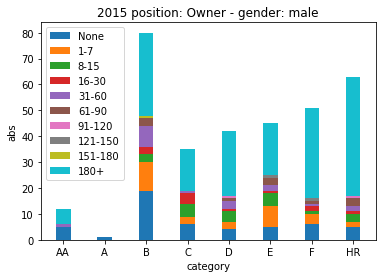

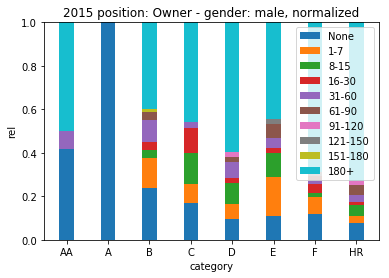

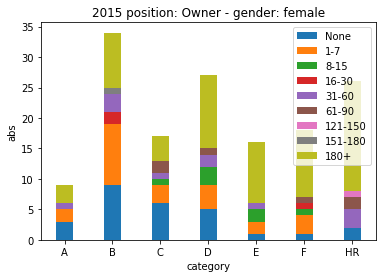

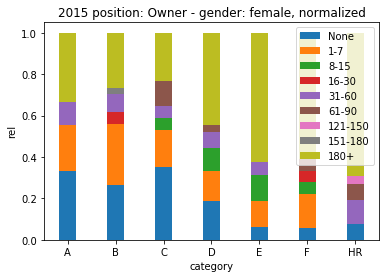

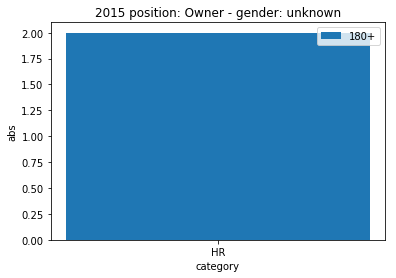

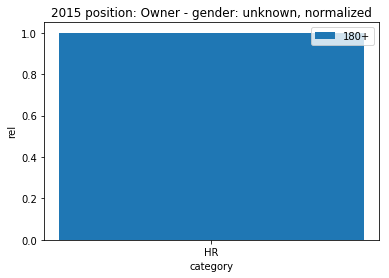

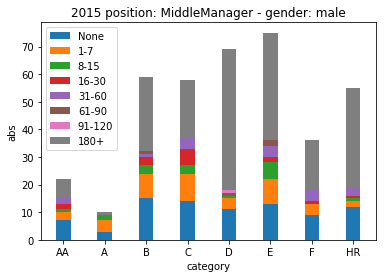

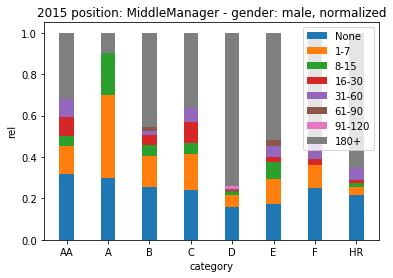

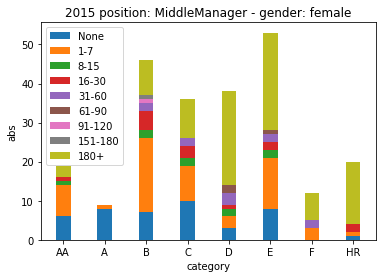

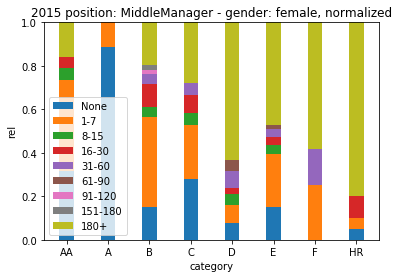

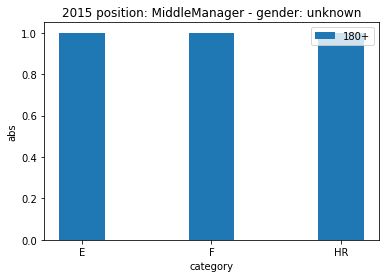

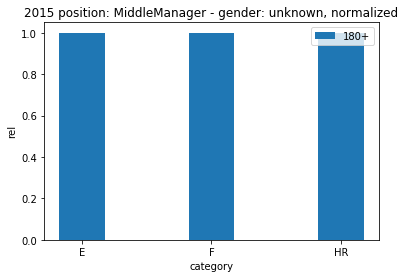

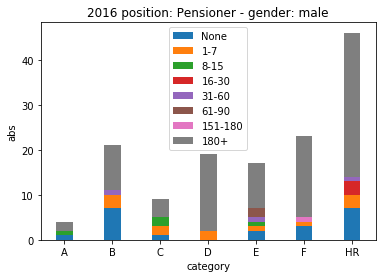

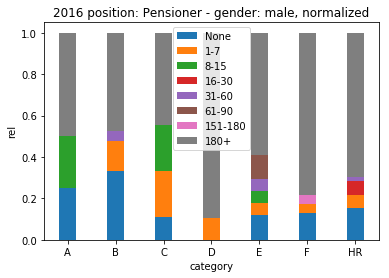

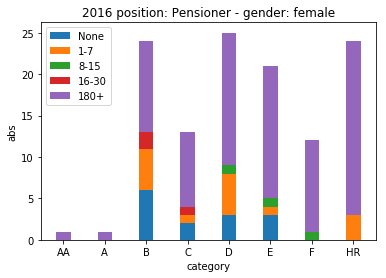

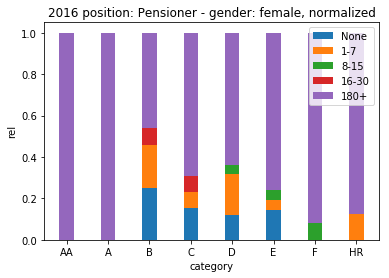

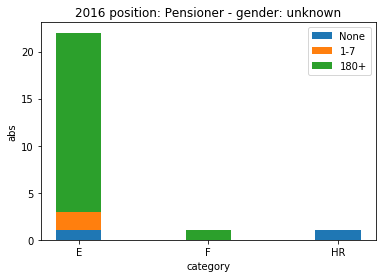

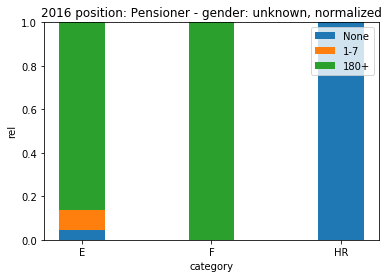

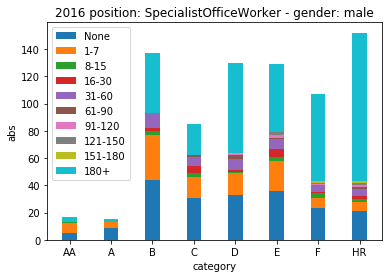

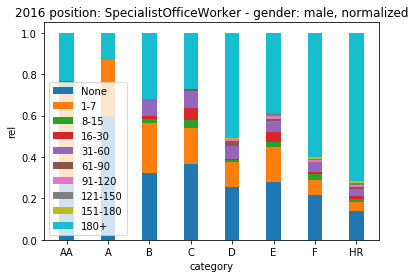

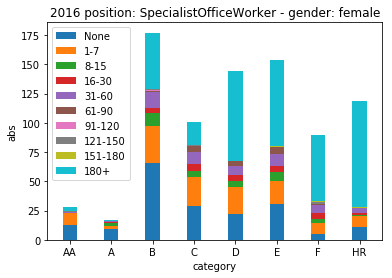

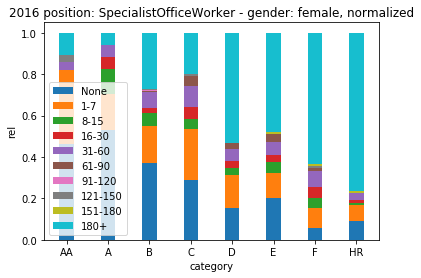

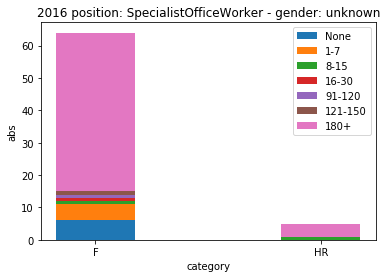

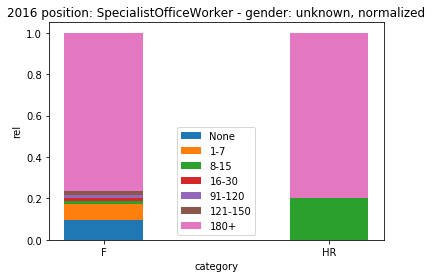

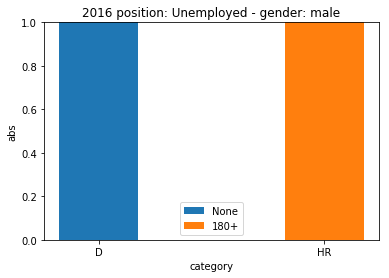

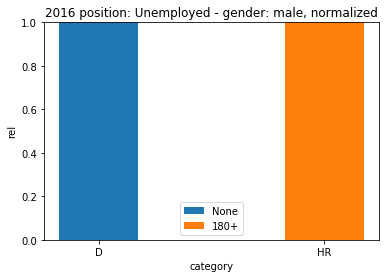

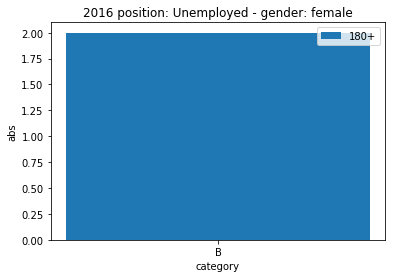

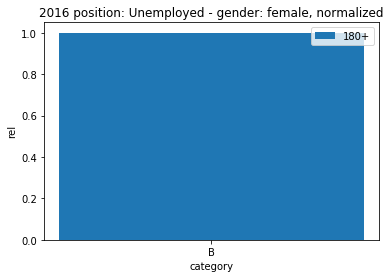

empty dataset
empty dataset


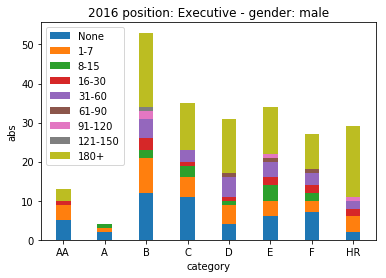

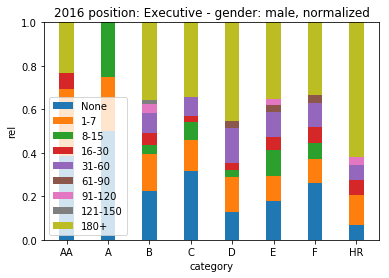

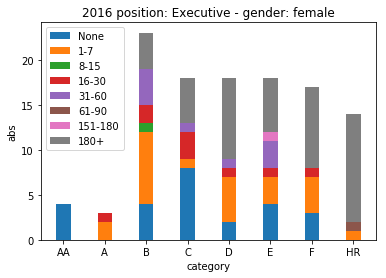

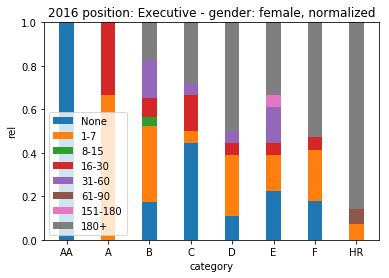

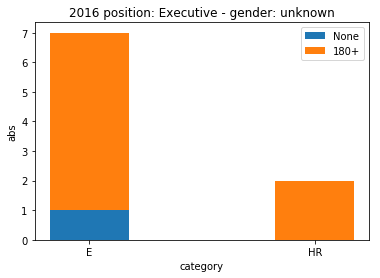

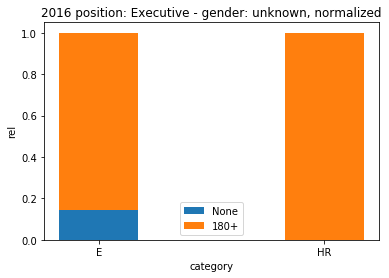

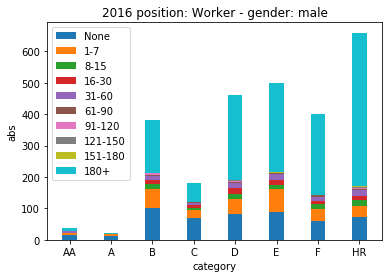

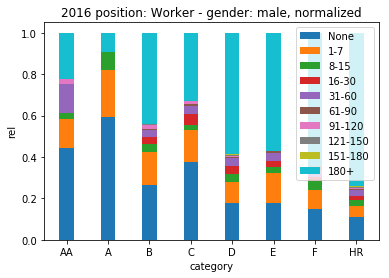

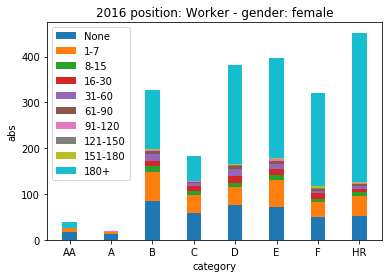

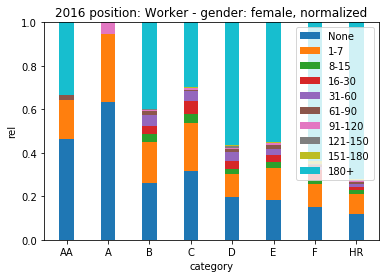

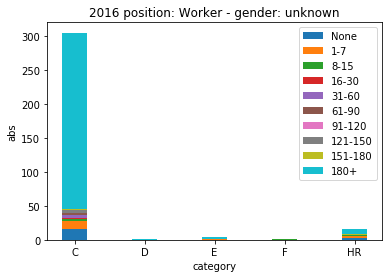

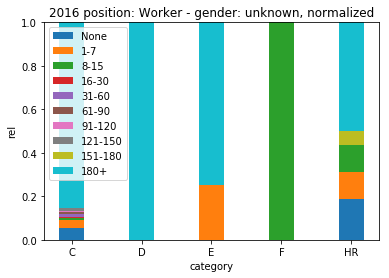

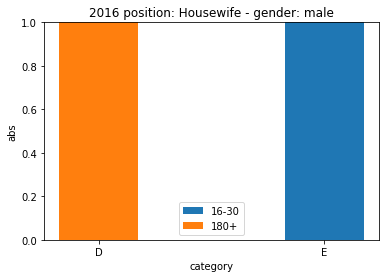

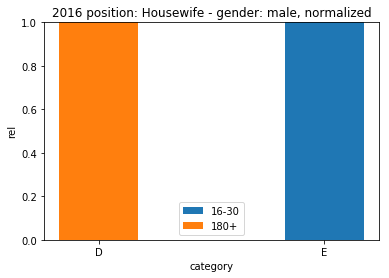

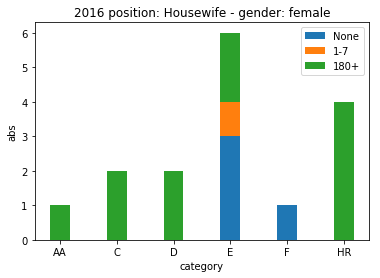

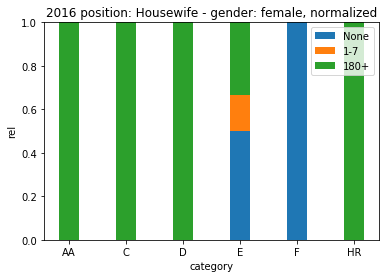

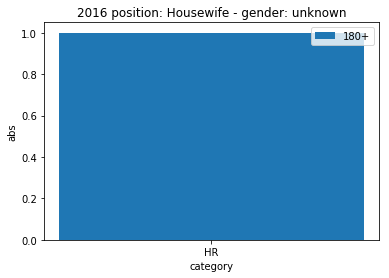

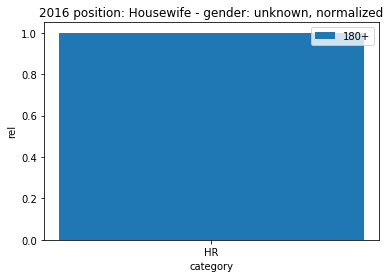

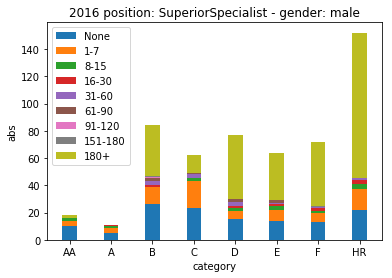

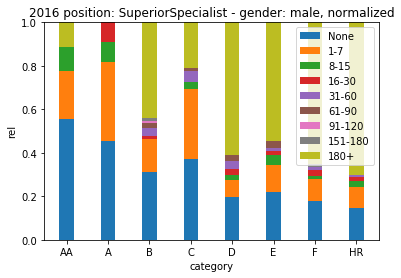

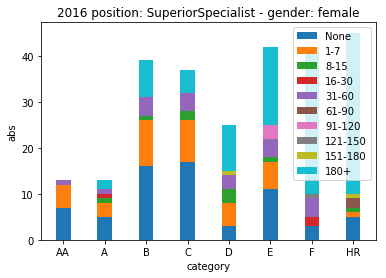

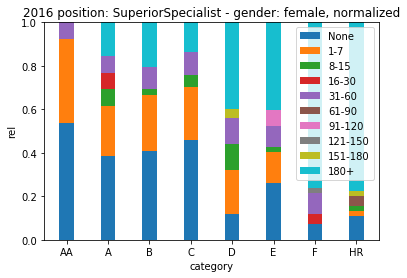

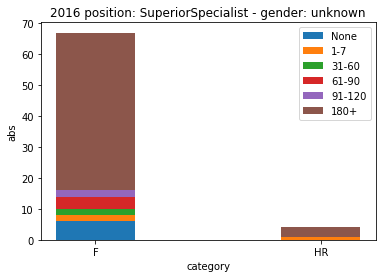

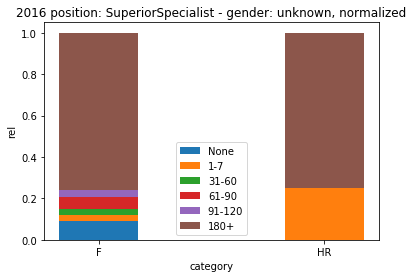

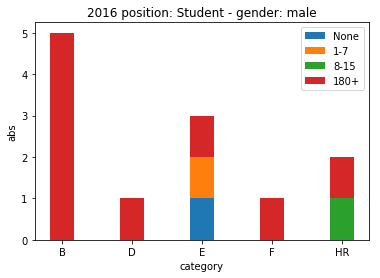

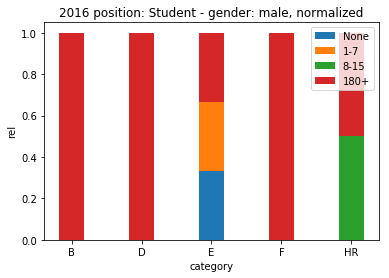

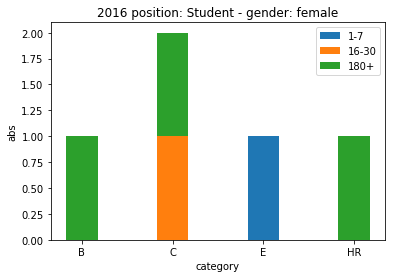

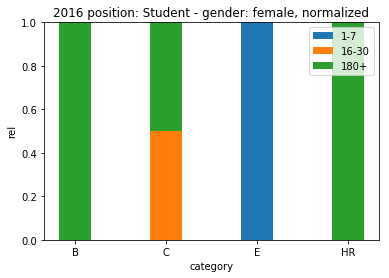

empty dataset
empty dataset


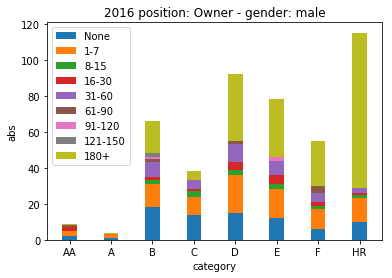

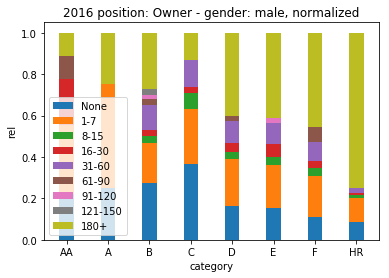

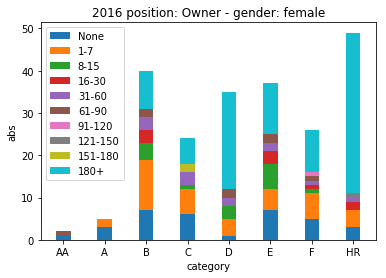

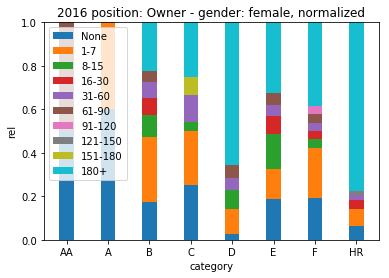

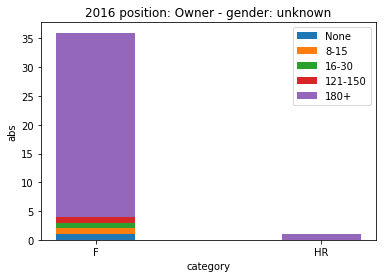

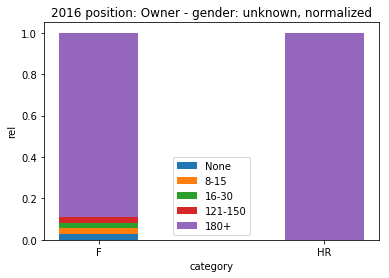

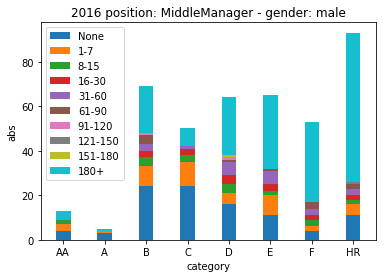

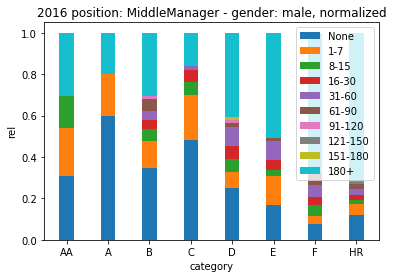

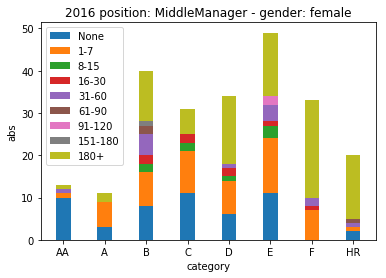

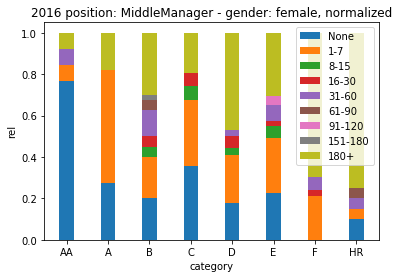

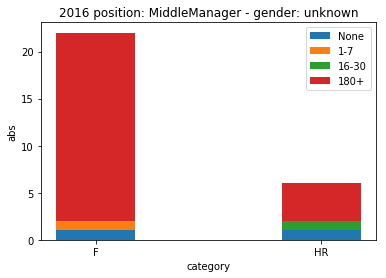

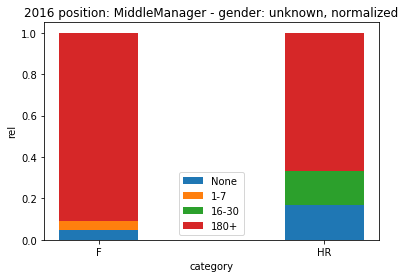

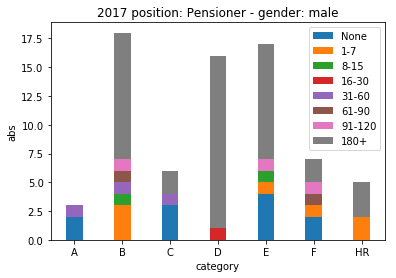

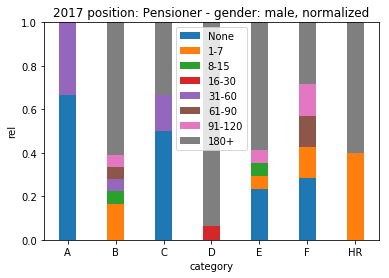

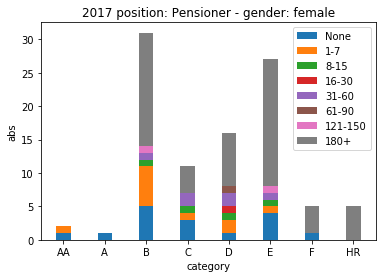

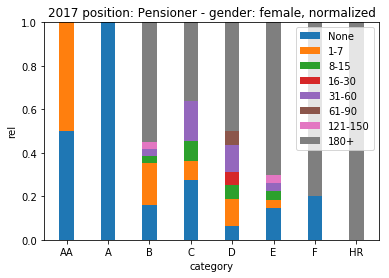

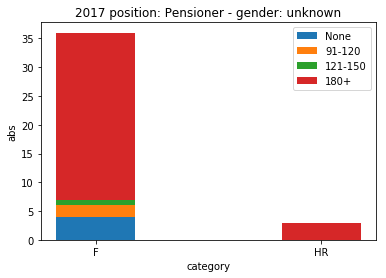

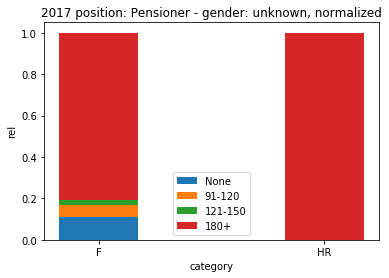

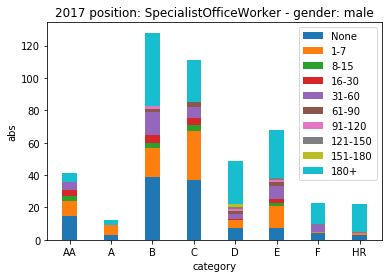

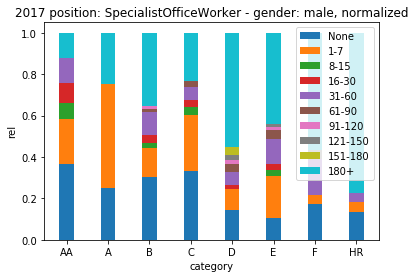

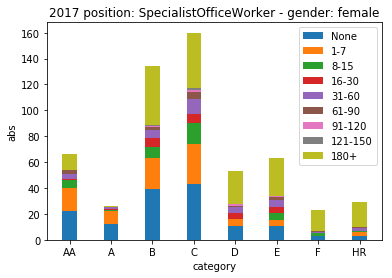

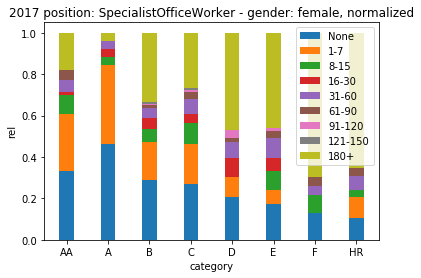

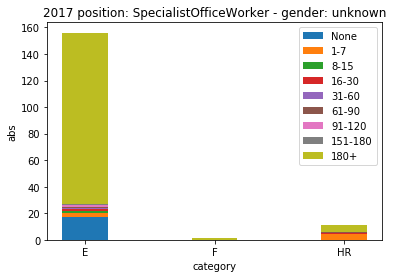

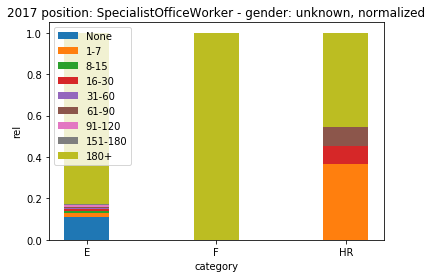

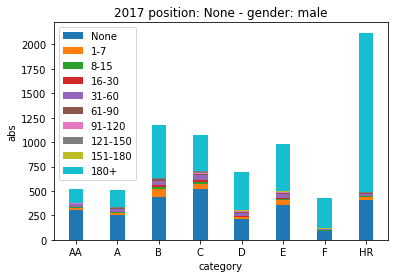

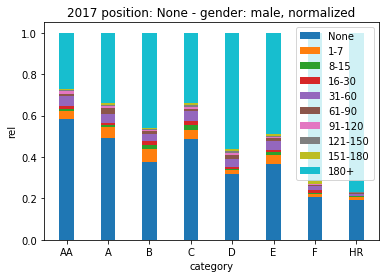

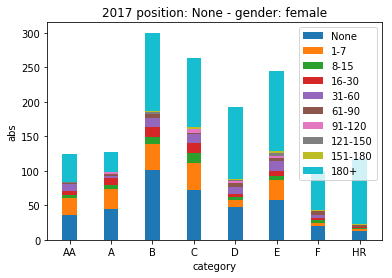

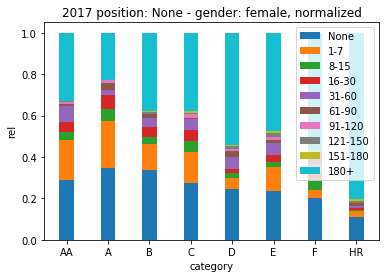

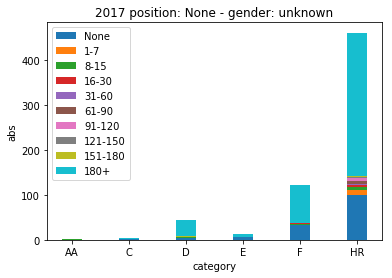

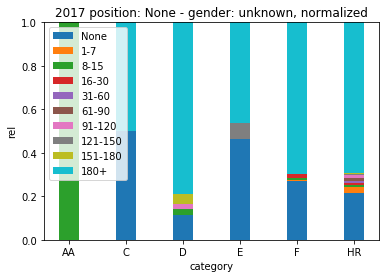

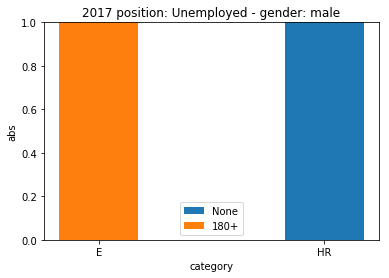

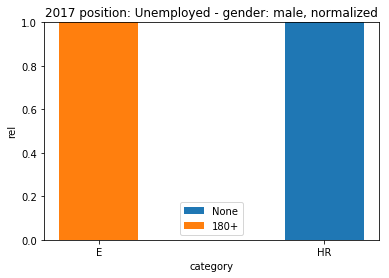

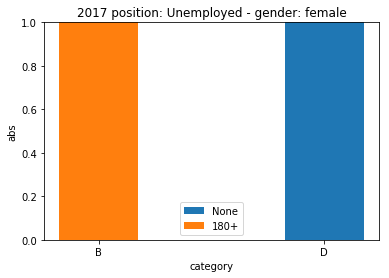

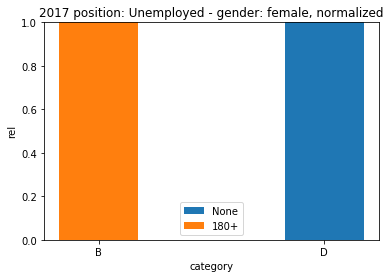

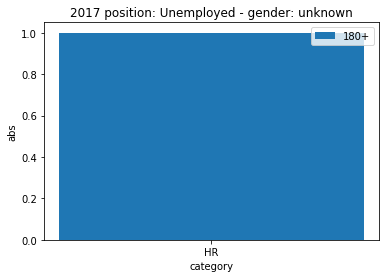

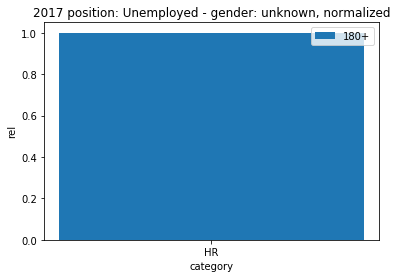

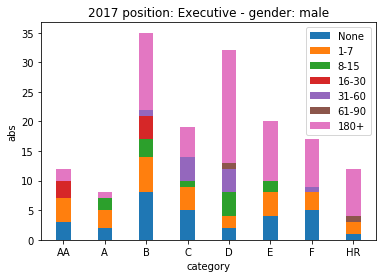

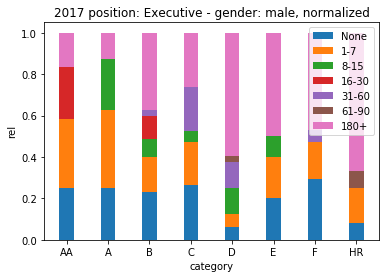

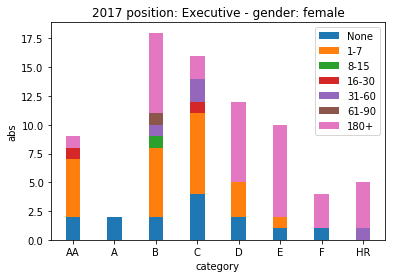

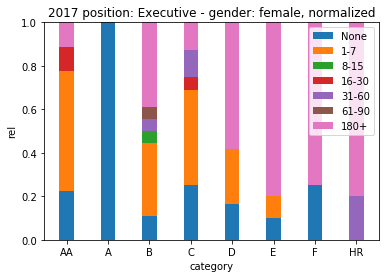

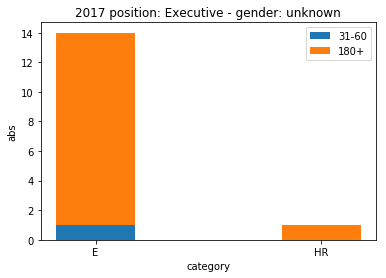

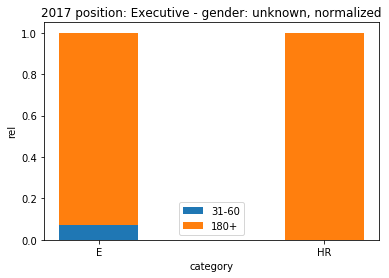

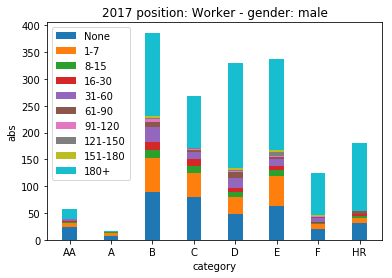

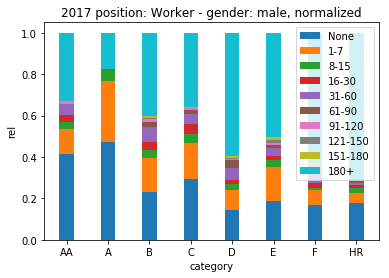

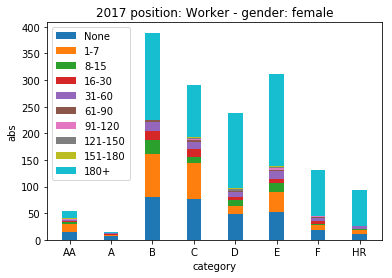

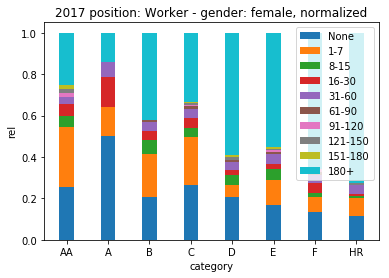

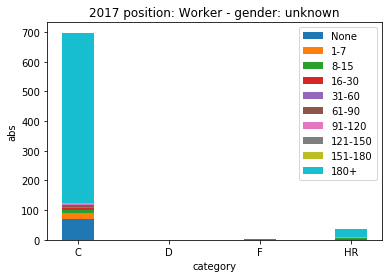

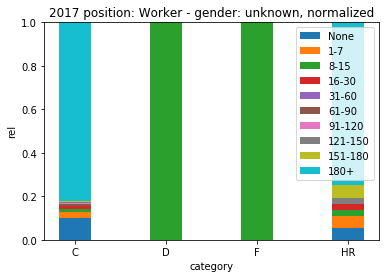

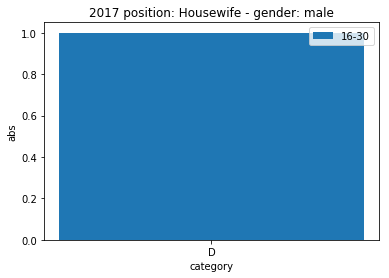

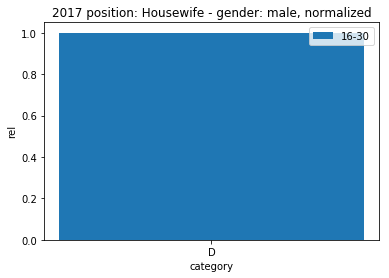

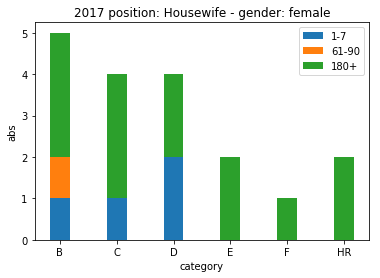

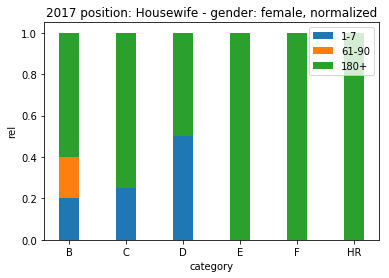

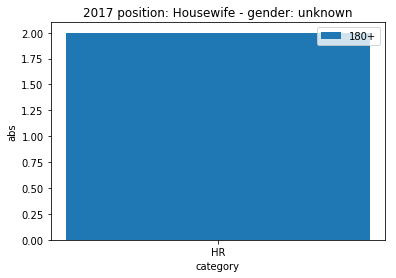

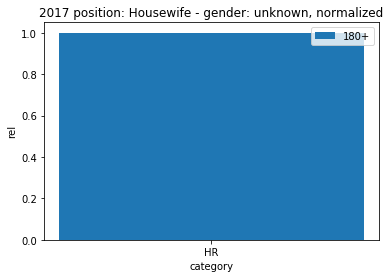

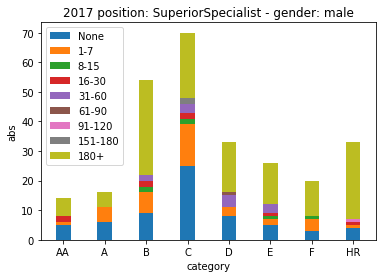

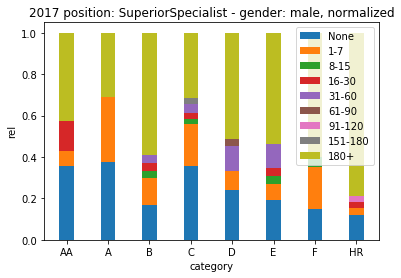

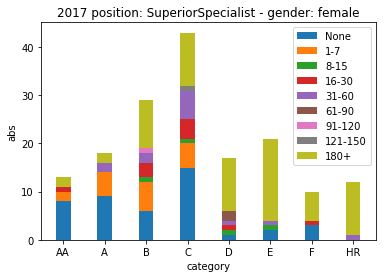

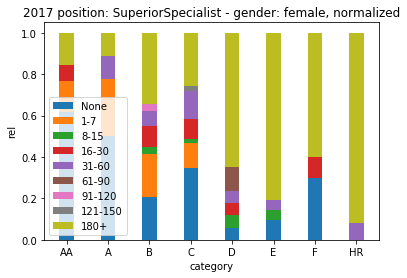

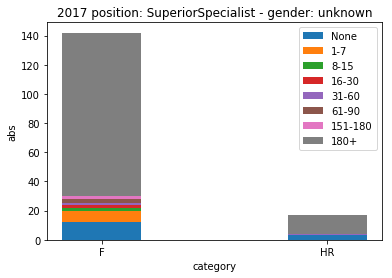

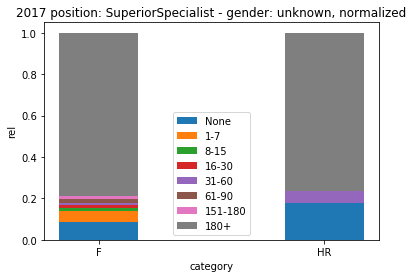

empty dataset
empty dataset


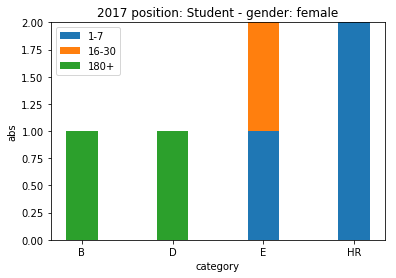

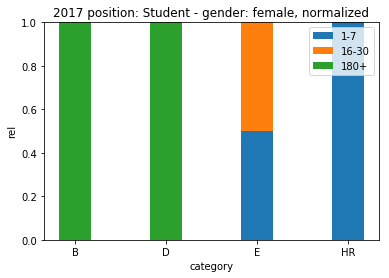

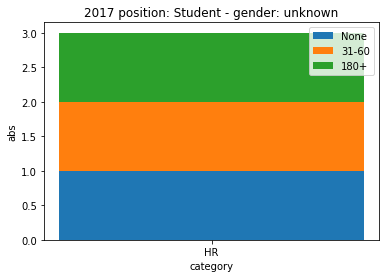

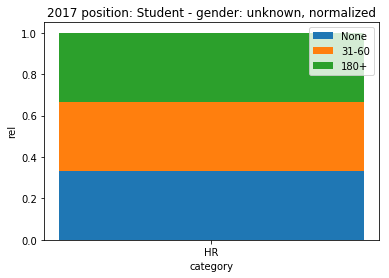

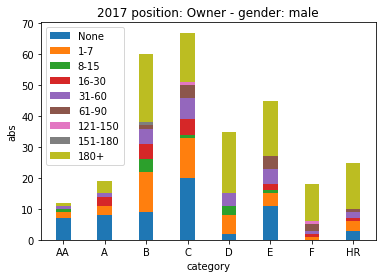

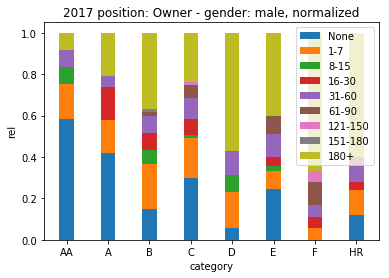

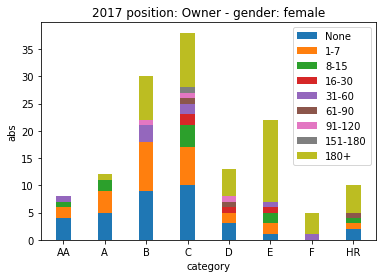

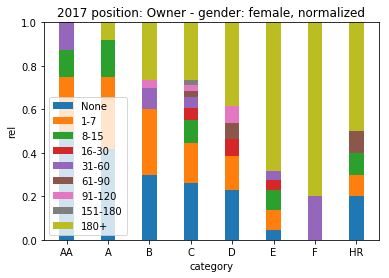

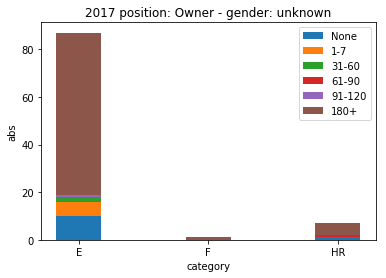

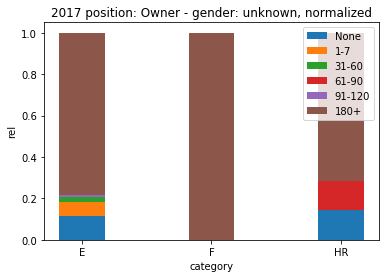

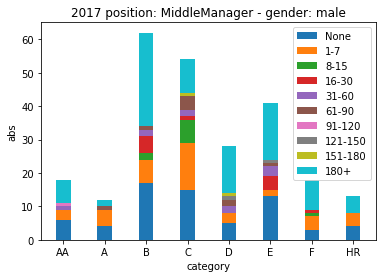

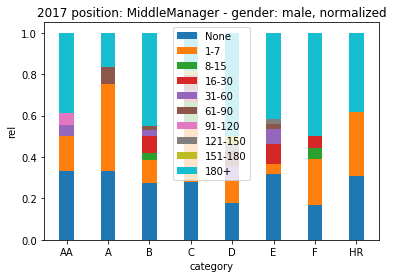

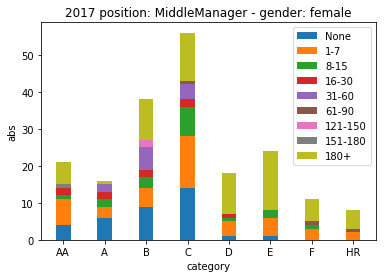

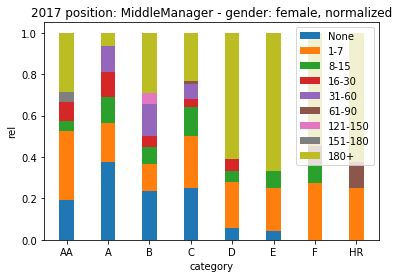

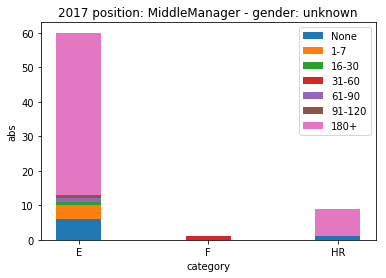

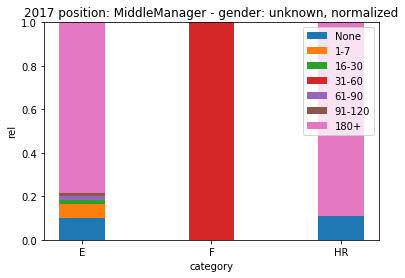

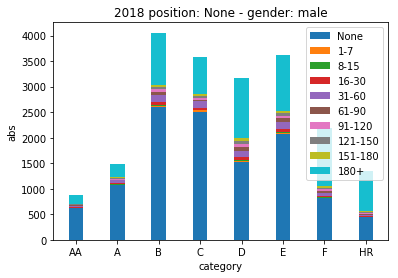

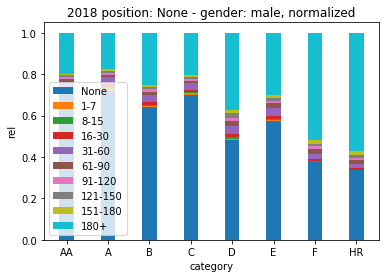

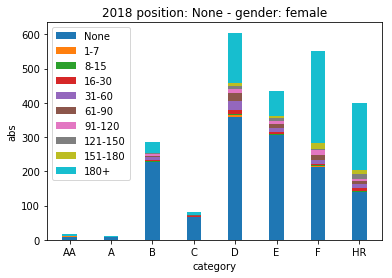

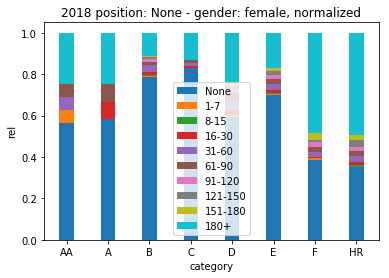

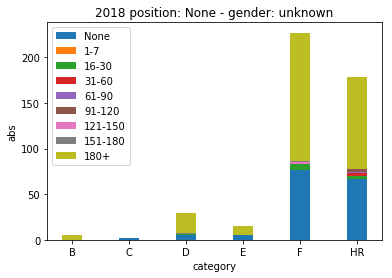

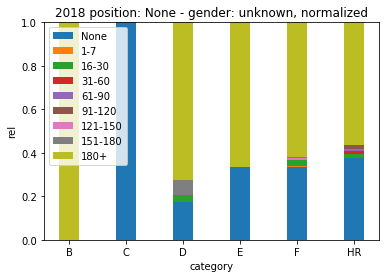

In [4]:
for year in range(2015,2019):
    for employ in getOptionSet(loansByYear[year],'EmploymentPosition'):
        for gender in [0, 1, 2]:
            barStacked(structureData(filterByValue(filterByValue(loansByYear[year], 'EmploymentPosition', employ), 'Gender', gender), ['Rating','WorseLateCategory']),title='{} position: {} - gender: {}'.format(year, employ, {0: 'male', 1: 'female', 2: 'unknown'}[gender]),yLabel='abs',normalize=False)
            barStacked(structureData(filterByValue(filterByValue(loansByYear[year], 'EmploymentPosition', employ), 'Gender', gender), ['Rating','WorseLateCategory']),title='{} position: {} - gender: {}, normalized'.format(year, employ, {0: 'male', 1: 'female', 2: 'unknown'}[gender]))